# Adversarial Attacks and Defenses

## Imports

In [1]:
# Imports
import pickle
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from keras.datasets import mnist
from torch import optim
import random
import numpy as np
import matplotlib.pyplot as plt
import copy
# Imports

Using TensorFlow backend.


## Set Parameters

In [0]:
img_rows = 28   #@param {type: "integer"}
img_cols = 28   #@param {type: "integer"}
model_path = "/content/trainedModel.p"  #@param {type: "string"}
model = None

## Load Dataset

In [3]:
# Load Data
print("Started Loading Data from mnist Dataset")
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Finished Loading Data from mnist Dataset")

print("Started Preprocessing")
x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train = np.array(x_train).reshape(60000, img_rows*img_cols)

print("X_train", x_train.shape)
print("Y_train", y_train.shape)
print("X_test", x_test.shape)
print("Y_test", y_test.shape)

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train.astype(int))
y_test = torch.from_numpy(y_test.astype(int))

print("Finished Preprocessing")
# Load Data

Started Loading Data from mnist Dataset
11493376/11490434 [==============================] - 2s 0us/step
Finished Loading Data from mnist Dataset
Started Preprocessing
X_train (60000, 784)
Y_train (60000,)
X_test (10000, 1, 28, 28)
Y_test (10000,)
Finished Preprocessing


## Load Model

### Model

In [0]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
# Imports

class BasicFNNModel(nn.Module):

    def __init__(self, n_inputs, n_outputs, hidden_sizes, act_funcs=[nn.Sigmoid()], out_act_funcs=[nn.Softmax(dim=1)]):
        super(BasicFNNModel, self).__init__()
        torch.manual_seed(0)

        # Fix act func sizes
        act_funcs = fix_act_funcs_size(len(hidden_sizes), act_funcs)

        seq = []

        seq.append(('input_layer', nn.Linear(n_inputs, hidden_sizes[0])))
        seq.append(('input_act_layer', act_funcs[0]))

        for i in range(1, len(hidden_sizes)):
            seq.append(('hidden_' + str(i), nn.Linear(hidden_sizes[i-1], hidden_sizes[i])))
            seq.append(('hidden_act_layer_' + str(i), act_funcs[i]))

        seq.append(('output_layer', nn.Linear(hidden_sizes[len(hidden_sizes)-1], n_outputs)))
        for index in range(len(out_act_funcs)):
            seq.append(('output_act_layer_' + str(index), out_act_funcs[index]))

        seqdict = OrderedDict(seq)

        print("Network Sequence: ", seqdict, "\n")

        self.net = nn.Sequential(
            seqdict
        )

    def getNetwork(self):
        return self.net

    def forward(self, X):
        return self.net(X)

    def predict(self, X):
        return self.net(X).detach().numpy()

    def weight_init(self, _type='kaiming'):
        if _type == 'kaiming':
            for ms in self._modules:
                kaiming_init(self._modules[ms].parameters())

    def fit(self, x, y, opt, loss_fn, epochs = 1000, display_loss=True):
        from torch import optim
        import matplotlib.pyplot as plt
        import matplotlib.colors
        import numpy as np
        import copy

        self.loss_fn = loss_fn
        # self.opt = opt

        y = y.nonzero()[:, 1]

        self.min_loss_config = None
        self.min_loss = -1

        loss_arr = []
        from tqdm import tqdm_notebook 
        for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
            self.cur_iter = i

            loss = loss_fn(self.forward(x), y)
            loss_temp = loss.item()
            loss_arr.append(loss_temp)

            loss.backward()
            opt.step()
            opt.zero_grad()

            if (self.min_loss == -1 or self.min_loss >= loss_temp):
                self.min_loss = loss_temp
                self.min_loss_config = copy.copy(self)

        if display_loss:
            plt.plot(loss_arr)
            plt.xlabel('Epochs')
            plt.ylabel('CE')
            plt.show()

        return loss_arr

def fix_act_funcs_size(size, act_funcs):
    afsize = len(act_funcs)
    fixed_act_funcs = []
    for i in range(size):
        if i < afsize:
            fixed_act_funcs.append(act_funcs[i])
        else:
            fixed_act_funcs.append(act_funcs[afsize-1])

    return fixed_act_funcs


def kaiming_init(ms):
    for m in ms:
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            nn.init.kaiming_uniform(m.weight, a=0, mode='fan_in')
            if m.bias.data:
                m.bias.data.zero_()
        if isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
            m.weight.data.fill_(1)
            if m.bias.data:
                m.bias.data.zero_()

### Train/Load Model

In [0]:
# One Hot Encoding
def OneHotEncode(X):
    Y = []
    for x in X:
        ohe = np.zeros(10)
        ohe[x] = 1
        Y.append(ohe)
        # print(x)
        # print(ohe)
    Y = np.array(Y)
    print(torch.from_numpy(Y.astype(int)).shape)
    return torch.from_numpy(Y.astype(int))

In [6]:
%%time
Retrain = False #@param {type:"boolean"}

if (Retrain or not os.path.exists(model_path)):
    model = BasicFNNModel(inpsize, outsize, hidden_layer_config, act_funcs, out_act_funcs)
    
    # Set Training Params
    act_funcs = [nn.ReLU()]
    out_act_funcs = [nn.Softmax(dim=1)]
    # Training
    display = True #@param {type:"boolean"}
    epochs = 10000  #@param {type: "integer"}
    lr = 0.01       #@param {type:"number"}
    momentum = 0.9  #@param {type:"number"}
    loss_fn = F.cross_entropy
    opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    inpsize = img_rows*img_cols
    outsize = 10
    hidden_layer_config = [64, 128, 256, 128, 64]
    # Set Training Params
    
    loss_arr = model.fit(x_train, OneHotEncode(y_train), opt, loss_fn, epochs, display)

    if (display):
        print("Losses: ", loss_arr)
        print("MinLoss: ", model.min_loss, " - ", model.min_loss_config.min_loss)
        print("Final Epoch: ", model.cur_iter)
        print("Best Epoch: ", model.min_loss_config.cur_iter)

    saveModel = True #@param {type:"boolean"}
    if (saveModel):
        if (os.path.exists(model_path)):
            os.remove(model_path)
        pickle.dump(model.min_loss_config, open(model_path, "wb"))
        print("Model Trained and Saved")

loadModel = True #@param {type:"boolean"}
if (loadModel):
    model = pickle.load(open(model_path, "rb")) # Load Best Model

CPU times: user 2.5 ms, sys: 97 µs, total: 2.6 ms
Wall time: 6.3 ms


## Attacks

### FGSM

#### Non Targeted and Targeted FGSM

In [0]:
# Normal FGSM
# Imports
from torch.autograd import Variable
# Imports

class FGSM:
    # Params
    
    # Params

    def __init__(self):
        self.enabled = True

    # Normal & Targeted FGSM
    def fgsm(self, x, y, net, loss_func, targeted=False, eps=0.03, x_val_min=-1, x_val_max=1):
        self.net = net
        self.loss_func = loss_func

        x_adv = Variable(x.data, requires_grad=True)
        h_adv = self.net(x_adv).reshape(1, -1)
        # print("DEBUG: h_adv shape: ", h_adv.shape, " - y shape: ", y.shape, " <-> y: ", y)

        if targeted:
            cost = self.loss_func(h_adv, y) # Should be positive
        else:
            cost = -self.loss_func(h_adv, y)# Should be negative

        self.net.zero_grad()
        if x_adv.grad is not None:
            x_adv.grad.data.fill_(0)
        cost.backward()

        x_adv.grad.sign_()
        x_adv = x_adv - eps*x_adv.grad
        x_adv = torch.clamp(x_adv, x_val_min, x_val_max)


        h = self.net(x)
        h_adv = self.net(x_adv)

        return np.array(x_adv.detach()), np.array(h_adv.detach()), np.array(h.detach())
    # Normal & Targeted FGSM

## Display

In [0]:
def Display(modelx, n_images, eps, columns, rows, displayChangedOnly, cmap, y_target=None):
    targeted = (not y_target==None)
    if targeted:
        print("Targeted FGSM")
        y_target = torch.from_numpy(np.array(y_target).reshape(-1))
    else:
        print("Non Targeted FGSM")
    for i in range(1, n_images+1):
        changed = True
        while changed:
            randindex = random.randint(0, np.array(x_test).shape[0]-1)
            x = np.array(x_test[randindex])
            x_flattened = torch.from_numpy(x.reshape(1, img_rows*img_cols))

            att_fgsm = FGSM()
            # x_adv_flattened - new image, h_adv - predicted for x_adv_flattened, h - predicted for original x
            if not targeted:
                y_pred = torch.from_numpy(np.array(y_test[randindex]).reshape(-1))
                x_adv_flattened, h_adv, h = att_fgsm.fgsm(x_flattened, y_pred, modelx.net, modelx.loss_fn, False, eps)
            else:
                x_adv_flattened, h_adv, h = att_fgsm.fgsm(x_flattened, y_target, modelx.net, modelx.loss_fn, True, eps)

            x_flattened = np.array(x_flattened)
            x_adv = x_adv_flattened.reshape(img_rows, img_cols)

            added_noise_flattened = x_adv_flattened - x_flattened
            added_noise = added_noise_flattened.reshape(img_rows, img_cols)
            if (not np.argmax(h) == np.argmax(h_adv) or not displayChangedOnly):
                changed = False
                print("Shapes: x: ", x.shape, ", x_flattened: ", x_flattened.shape, 
                ", x_adv: ", x_adv.shape, ", x_adv_flattened: ", x_adv_flattened.shape)

                print("Y_pred before attack: ", str(np.argmax(h)))
                print("Y_pred after attack: ", str(np.argmax(h_adv)))
                print("Y_pred Values before attack: ", str(h))
                print("Y_pred Values after attack: ", str(h_adv))

                
                fig = plt.figure(figsize=(8, 8))
                fig.add_subplot(rows, columns, 1)
                plt.imshow(x[0], cmap=cmap)
                fig.add_subplot(rows, columns, 1+1)
                plt.imshow(added_noise, cmap=cmap)
                fig.add_subplot(rows, columns, 1+2)
                plt.imshow(x_adv, cmap=cmap)
                plt.show()

Cmaps

```
'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 
'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu',
'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn',
'YlGn'
```

Non Targeted FGSM
Shapes: x:  (1, 28, 28) , x_flattened:  (1, 784) , x_adv:  (28, 28) , x_adv_flattened:  (1, 784)
Y_pred before attack:  8
Y_pred after attack:  7
Y_pred Values before attack:  [[4.2019049e-10 2.1998101e-17 2.9166258e-14 2.3297568e-08 9.1727613e-18
  1.7207018e-15 2.0988593e-15 1.2439379e-20 1.0000000e+00 6.9698132e-13]]
Y_pred Values after attack:  [[0.0000000e+00 2.6899383e-07 0.0000000e+00 2.8117001e-04 0.0000000e+00
  0.0000000e+00 0.0000000e+00 9.9971849e-01 2.5839944e-42 0.0000000e+00]]


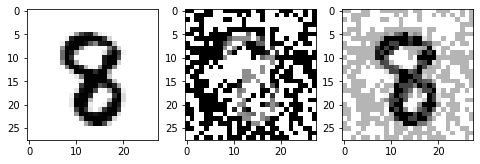

Shapes: x:  (1, 28, 28) , x_flattened:  (1, 784) , x_adv:  (28, 28) , x_adv_flattened:  (1, 784)
Y_pred before attack:  0
Y_pred after attack:  6
Y_pred Values before attack:  [[1.0000000e+00 4.2403292e-42 4.0454452e-28 5.5578835e-23 7.7638566e-25
  1.0080000e-24 6.4282464e-09 0.0000000e+00 3.7242466e-16 2.6568058e-40]]
Y_pred Values after attack:  [[4.3397930e-07 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.4715573e-27
  0.0000000e+00 9.9999952e-01 0.0000000e+00 1.3388266e-37 0.0000000e+00]]


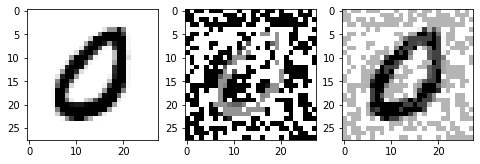

Shapes: x:  (1, 28, 28) , x_flattened:  (1, 784) , x_adv:  (28, 28) , x_adv_flattened:  (1, 784)
Y_pred before attack:  3
Y_pred after attack:  7
Y_pred Values before attack:  [[1.2871801e-03 2.9941310e-14 1.0514636e-11 9.8852557e-01 3.9381486e-23
  7.4012123e-13 1.2735260e-15 2.0949781e-14 1.0187275e-02 4.0498634e-17]]
Y_pred Values after attack:  [[0.000000e+00 5.804202e-07 0.000000e+00 5.965601e-07 0.000000e+00
  0.000000e+00 0.000000e+00 9.999988e-01 0.000000e+00 0.000000e+00]]


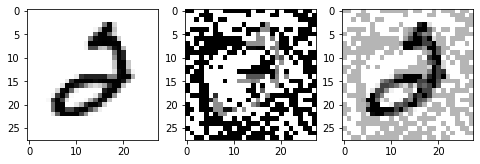

In [9]:
n_images = 3    #@param {type: "integer"}
eps = 0.25      #@param {type:"slider", min:0, max:5, step:0.01}
displayChangedOnly = True   #@param {type: "boolean"}
columns = 3     #@param {type: "integer"}
rows = 1        #@param {type: "integer"}
cmap = 'Greys'  #@param {type: "string"}
modelx = model

targeted = False#@param {type: "boolean"}
y_target = 6    #@param {type:"slider", min:0, max:9}
if not targeted:
    y_target = None

Display(modelx=modelx, n_images=n_images, eps=eps, columns=columns, rows=rows, displayChangedOnly=displayChangedOnly, cmap=cmap, y_target=y_target)

## Outputs

## Defenses

In [0]:
def AdversarialTraining(modelx, X, Y, n_train, n_eps=10, max_eps=1, eps_resolution=2, targeted=False, displayIndex=False):
    print("targeted ", targeted)
    att_fgsm = FGSM()
    x_advs_flattened = []
    y_advs = []

    rand_indices = random.sample(range(X.shape[0]), n_train)
    for i in rand_indices:
        x = np.array(X[i])
        x_flattened = torch.from_numpy(x.reshape(1, img_rows*img_cols))
        rand_eps = np.array(random.sample(range(int(max_eps*(10**eps_resolution))), n_eps)) / (10**eps_resolution)
        for e in rand_eps:
            # x_adv_flattened - new image, h_adv - predicted for x_adv_flattened, h - predicted for original x
            if not targeted:
                y_pred = torch.from_numpy(np.array(Y[i]).reshape(-1))
                x_adv_flattened, h_adv, h = att_fgsm.fgsm(x_flattened, y_pred, modelx.net, modelx.loss_fn, False, e)
            else:
                y_target = random.randint(0, 9)
                y_target = torch.from_numpy(np.array(y_target).reshape(-1))
                x_adv_flattened, h_adv, h = att_fgsm.fgsm(x_flattened, y_target, modelx.net, modelx.loss_fn, True, e)
            if (displayIndex):
                print("index: ", i, " - eps: ", e, " - before: ", np.argmax(h), " - after: ", np.argmax(h_adv))
            if (not (np.argmax(h_adv) == np.argmax(h))):
                x_advs_flattened.append(x_adv_flattened[0])
                y_advs.append(Y[i])

    # Training
    x_advs_flattened = torch.from_numpy(np.array(x_advs_flattened))
    y_advs = torch.from_numpy(np.array(y_advs))
    print("Training ", x_advs_flattened.shape[0], " images")
    loss_arr = modelx.fit(x_advs_flattened, OneHotEncode(y_advs), opt_def, modelx.loss_fn, epochs_def, False)

    return modelx

In [0]:
# Set Training Params
# Training
model_def = model
Retrain_def = True  #@param {type: "boolean"}
if (not Retrain_def):
    model_adv = copy.copy(model_def)
display_def = False #@param {type:"boolean"}
epochs_def = 100  #@param {type: "integer"}
lr_def = 0.01       #@param {type:"number"}
momentum_def = 0.9  #@param {type:"number"}
opt_def = optim.SGD(model_adv.parameters(), lr=lr_def, momentum=momentum_def)
# Set Training Params

In [56]:
n_train = 50        #@param {type: "integer"}
n_eps = 2          #@param {type: "integer"}
max_eps = 1.0       #@param {type:"slider", min:0, max:5, step:0.01}
eps_resolution = 2  #@param {type: "integer"}
targeted = False    #@param {type: "boolean"}
X = x_test.reshape(-1, img_rows*img_cols)
Y = y_test
model_adv = AdversarialTraining(modelx=model_adv, 
        X=X, Y=Y, 
                            n_train=n_train, n_eps=n_eps, 
                            max_eps=max_eps, 
                            eps_resolution=eps_resolution, 
                            targeted=targeted, 
                            displayIndex=False)

targeted  False
Training  91  images
torch.Size([91, 10])


Non Targeted FGSM
Shapes: x:  (1, 28, 28) , x_flattened:  (1, 784) , x_adv:  (28, 28) , x_adv_flattened:  (1, 784)
Y_pred before attack:  1
Y_pred after attack:  1
Y_pred Values before attack:  [[1.6900583e-34 1.0000000e+00 6.2176315e-22 1.4637130e-10 1.4012985e-45
  2.6287113e-26 3.7835059e-44 5.6354235e-08 1.0441944e-18 1.0987296e-22]]
Y_pred Values after attack:  [[0.0000000e+00 9.9999928e-01 4.2477279e-29 1.2246719e-10 0.0000000e+00
  6.7102547e-36 0.0000000e+00 7.6537651e-07 2.6948690e-26 2.6917578e-32]]


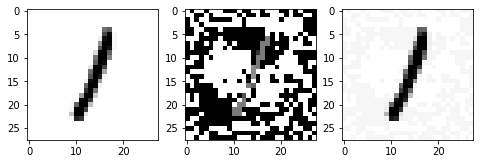

Shapes: x:  (1, 28, 28) , x_flattened:  (1, 784) , x_adv:  (28, 28) , x_adv_flattened:  (1, 784)
Y_pred before attack:  3
Y_pred after attack:  3
Y_pred Values before attack:  [[6.7549568e-26 3.1581127e-08 3.3455936e-25 1.0000000e+00 0.0000000e+00
  3.5267050e-31 0.0000000e+00 3.0745076e-10 3.6296139e-17 7.9162580e-33]]
Y_pred Values after attack:  [[1.6815582e-44 1.0040858e-03 7.8722134e-32 9.9878877e-01 0.0000000e+00
  1.5742187e-41 0.0000000e+00 2.0718426e-04 3.8880717e-26 2.7116947e-40]]


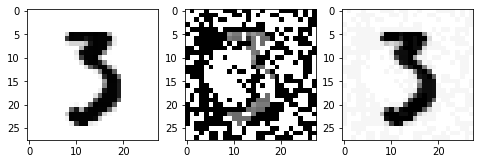

Shapes: x:  (1, 28, 28) , x_flattened:  (1, 784) , x_adv:  (28, 28) , x_adv_flattened:  (1, 784)
Y_pred before attack:  1
Y_pred after attack:  1
Y_pred Values before attack:  [[1.7518250e-21 6.8859607e-01 9.3866138e-22 3.1140396e-01 0.0000000e+00
  2.8790348e-26 0.0000000e+00 7.1263282e-12 1.6276244e-11 3.9361584e-29]]
Y_pred Values after attack:  [[5.61985704e-38 9.99999642e-01 9.39639938e-28 3.37585277e-07
  0.00000000e+00 3.65797863e-34 0.00000000e+00 1.50984156e-10
  2.40044292e-20 1.05414814e-32]]


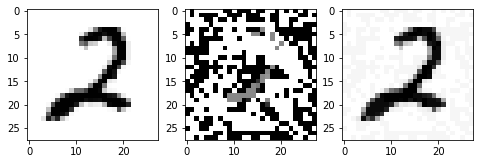

In [61]:
n_images = 3    #@param {type: "integer"}
eps = 0.04      #@param {type:"slider", min:0, max:5, step:0.01}
displayChangedOnly = False   #@param {type: "boolean"}
columns = 3     #@param {type: "integer"}
rows = 1        #@param {type: "integer"}
cmap = 'Greys'  #@param {type: "string"}
modelx = model_adv

targeted = False#@param {type: "boolean"}
y_target = 6    #@param {type:"slider", min:0, max:9}
if not targeted:
    y_target = None

Display(modelx=modelx, n_images=n_images, eps=eps, columns=columns, rows=rows, displayChangedOnly=displayChangedOnly, cmap=cmap, y_target=y_target)